# Make Baseline Dataset

Create the dataset that we will use to develop a baseline score. 

### Imports

In [4]:
# import sys
# sys.path.append('../../../')
from src.data.make_features_dataset import *

%load_ext autoreload
%autoreload 2


## Steps:

The following steps are done for all timesteps (TS) and bands (B). 

There are 11 timesteps and 14 bands - `11 x 14 = 154`, which will be interesting later

### 1. Mask raster with shapefile

Using the given `train` and `test` shapefiles, "mask" the polygons from the raster (image).

### 2. Reduce masked bands to descriptive stats

Each masked band gives a numpy array of variable shape. For the baseline, we will calculate descriptive stats for each mask, such as the `mean` and `std` of the values. 

Exactly _what_ we calculate will most likely be fiddled with to create better models.


### 0. Load Data

In [5]:
dataset = 'train'

print('Reading shapefile...', end='')
shp_df = read_shapefile(dataset)
print('done.')

safe_dirs = get_safe_dirs()
safe_dir = safe_dirs[0]

# Get timestamp (str)
date = date_from_safedir(safe_dir)

print('Reading image bands...', end='')
img_band_fpaths = glob(f'{safe_dir}/**/IMG_DATA/*.jp2', recursive=True)
print('done.')

print(f'Found {len(img_band_fpaths)} image bands to process')

Reading shapefile...done.
Reading image bands...done.
Found 14 image bands to process


In [6]:
shp_df.geometry.head()

Field_Id
1    POLYGON ((613924.3324000851 6793991.295069702,...
2    POLYGON ((614404.0717397591 6794020.579634549,...
3    POLYGON ((614320.2146632321 6793964.242091182,...
4    POLYGON ((614560.5326844405 6794002.249461887,...
7    POLYGON ((614596.6564746551 6794269.865436315,...
Name: geometry, dtype: object

## 1. Mask Shapes from Raster

In [12]:
# Prototype on one band
img_fpath = img_band_fpaths[1]

# Get the date from the image path
date = date_from_safedir(safe_dir)

# Get the name of the band from the image filepath
band = band_from_imgpath(img_fpath)

print('Date: ',date)
print('Band: ',band)

Date:  2017-07-10
Band:  TCI


**Extract shapes (mask) from image raster**

In [38]:
with rasterio.open(img_fpath) as raster:
    print('Masking raster...', end='')
    masks = mask_raster(shp_df.geometry, raster) 
    print(f'{len(masks)} farms successfully masked')

Masking raster...2344 farms successfully masked


### View a random masked shape

(3, 16, 16)


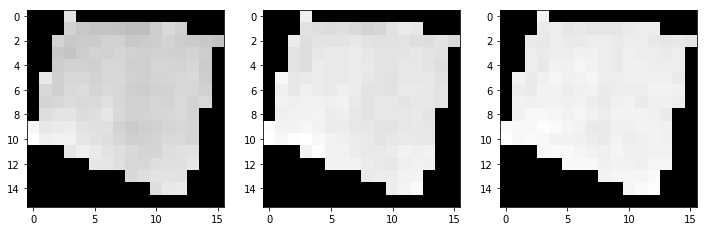

In [39]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

ids = list(masks.keys())

random_mask = masks[np.random.choice(ids)]

print(random_mask.shape)

# Show all three bands in mask
fig, ax = plt.subplots(ncols=3, figsize=(12,8))

ax[0].imshow(random_mask[0], cmap='gray')
ax[1].imshow(random_mask[1], cmap='gray')
ax[2].imshow(random_mask[2], cmap='gray')

## 2. Calculate descriptive stats for each mask

In [41]:
mask_data = {idx: reduce_img(img) for idx, img in masks.items()}

mask_df = features_dict_to_dataframe(mask_data, band)
mask_df.head(10)

,TCI_width,TCI_height,TCI_size,TCI_mean,TCI_std
Field_Id,,,,,
19,20,13,260,91.308974,49.464187
20,11,23,253,65.762846,38.705559
21,21,6,126,39.497354,44.557866
22,23,14,322,74.063147,39.331146
24,8,28,224,62.531250,35.584728
25,5,20,100,49.533333,44.232442
26,6,20,120,72.944444,34.330780
27,23,18,414,52.700483,37.459528
29,15,21,315,53.295238,35.827905


--> Some basic descriptive stats for each image

**NB: Shapes out of bounds** 

Some shapes in the shapefile are outside of the raster dimensions. For the training dataset, we are ignoring these. 

_For the testing dataset we need to include them, so we will be returning just ones for those missing shapes._

### Now do that for multiple bands and combine into one dataframe

In [44]:
# Now do that for multiple bands and combine
mask_dfs = []
for img_fpath in img_band_fpaths[:3]:
    
    band = band_from_imgpath(img_fpath)
    print('Processing band ', band)
    with rasterio.open(img_fpath) as raster:

        print('Masking raster...', end='')
        masks = mask_raster(shp_df.geometry, raster, return_missing=False) # Return missing will be True when running on test set
        print(f'{len(masks)} farms successfully masked')

        # Calculate descriptive stats for each mask
        # and get the names of features calculated
        mask_data = {idx: reduce_img(img) for idx, img in masks.items()}

        mask_df = features_dict_to_dataframe(mask_data, band)
    
    mask_dfs.append(mask_df)

Processing band  B08
Masking raster...2344 farms successfully masked
Processing band  TCI
Masking raster...2344 farms successfully masked
Processing band  B09
Masking raster...2344 farms successfully masked


In [45]:
df = pd.concat(mask_dfs, axis=1)
df = df.merge(shp_df.Crop_Id_Ne, left_index=True, right_on='Field_Id', how='left')
df.head()

,B08_width,B08_height,B08_size,B08_mean,B08_std,TCI_width,TCI_height,TCI_size,TCI_mean,TCI_std,B09_width,B09_height,B09_size,B09_mean,B09_std,Crop_Id_Ne
Field_Id,,,,,,,,,,,,,,,,
19,20,13,260,1949.619231,991.590718,20,13,260,91.308974,49.464187,4,3,12,500.000000,500.239776,8
20,11,23,253,1591.383399,931.566898,11,23,253,65.762846,38.705559,3,5,15,192.466667,384.978591,8
21,21,6,126,863.079365,970.215060,21,6,126,39.497354,44.557866,4,2,8,112.500000,297.647022,8
22,23,14,322,1608.388199,846.305729,23,14,322,74.063147,39.331146,5,3,15,472.666667,442.541097,8
24,8,28,224,1491.866071,847.789315,8,28,224,62.531250,35.584728,3,5,15,288.066667,408.429589,8


### Done!

We now have a way of calculating a baseline model

All of this is combined into one script `src.data.create_features_dataset.py`